In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
%matplotlib inline
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


In [2]:
sales=pd.read_csv("Orders-Table 1.csv")

#formatting the date column correctly
sales.date=sales.OrderDate.apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%y'))
# check
print(sales.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
OrderDate        9994 non-null object
Ship Date        9994 non-null object
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: float64(3), int64(3), object(15)
memory usage: 1.6+ MB
None


/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [3]:
sales['orderyear'] = sales.date.dt.year
sales['ordermonth'] = sales.date.dt.month


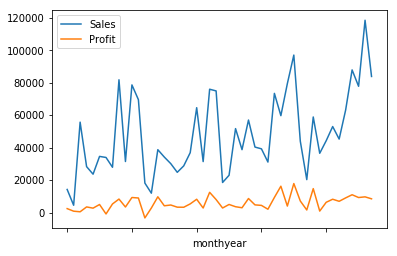

In [4]:
sales['monthyear'] = sales.apply(lambda row :
                          (row.orderyear,row.ordermonth), 
                                    axis=1)
newdf = sales[['monthyear', 'Sales', 'Profit']].copy()

newdf.groupby([newdf.monthyear]).sum().plot()

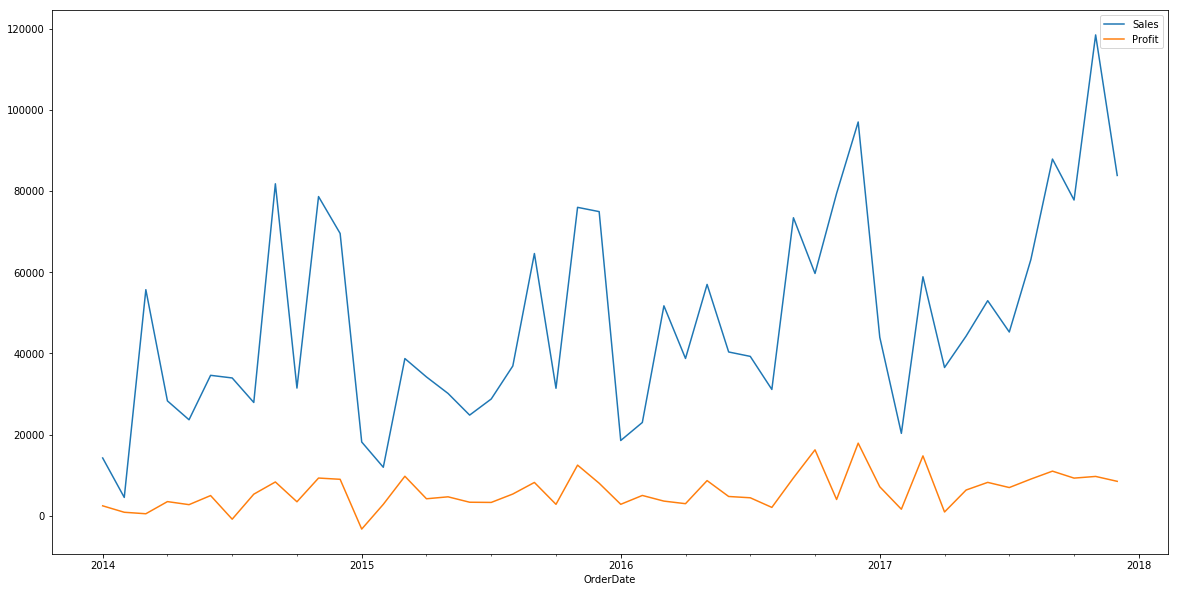

In [5]:
# matplotlibdf = pd.read_csv("Orders-Table 1.csv",parse_dates=['OrderDate'], index_col='OrderDate')
matplotlibdf = sales[['OrderDate', 'Sales', 'Profit']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
#matplotlibdf.Sales.resample('M',how='sum')
#matplotlibdf
linechartData = matplotlibdf.groupby([pd.Grouper(freq='MS',key='OrderDate')]).sum()
linechartData.plot(figsize=(20,10))

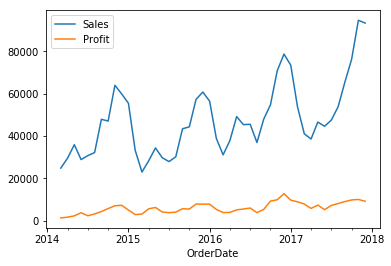

In [6]:
# Plotting Rolling mean

linechartData.rolling(window=3).mean().plot()

/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


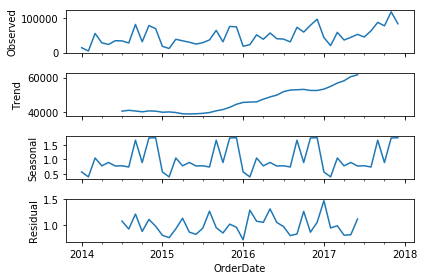

In [7]:
import statsmodels.api as sm
# multiplicative

res = sm.tsa.seasonal_decompose(linechartData.Sales,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [8]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs



# Stationarity tests
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    


In [9]:

print("For Sales")
test_stationarity(linechartData.iloc[:,0].values)
print("\n\nFor Profit")
test_stationarity(linechartData.iloc[:,1].values)


For Sales
Results of Dickey-Fuller Test:
Test Statistic                 -4.493768
p-value                         0.000202
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


For Profit
Results of Dickey-Fuller Test:
Test Statistic                 -2.828475
p-value                         0.054320
#Lags Used                      3.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


Negative test statistic and p value less than 0.05 means values are stationary. 

In [10]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

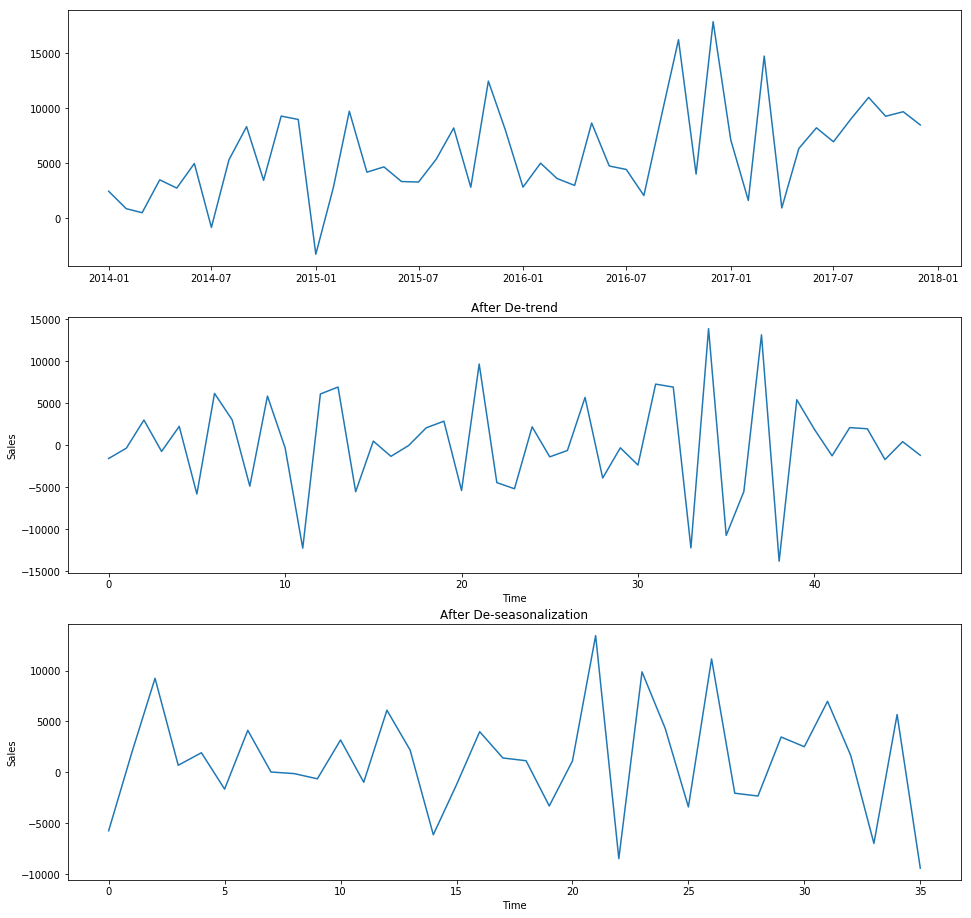

In [11]:
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.plot(linechartData.Profit)
plt.plot()

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(linechartData.Profit)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(linechartData.Profit,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [12]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -8.662415e+00
p-value                        4.782827e-14
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+01
Critical Value (1%)           -3.632743e+00
Critical Value (5%)           -2.948510e+00
Critical Value (10%)          -2.613017e+00
dtype: float64


In [13]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

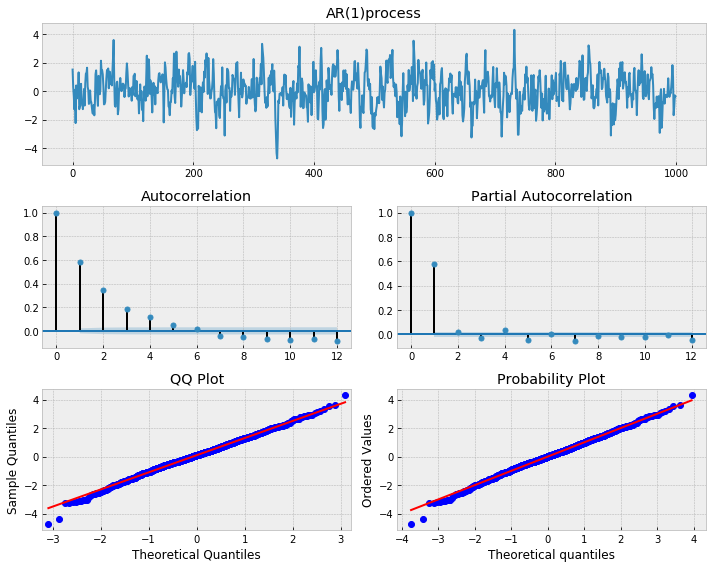

In [14]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

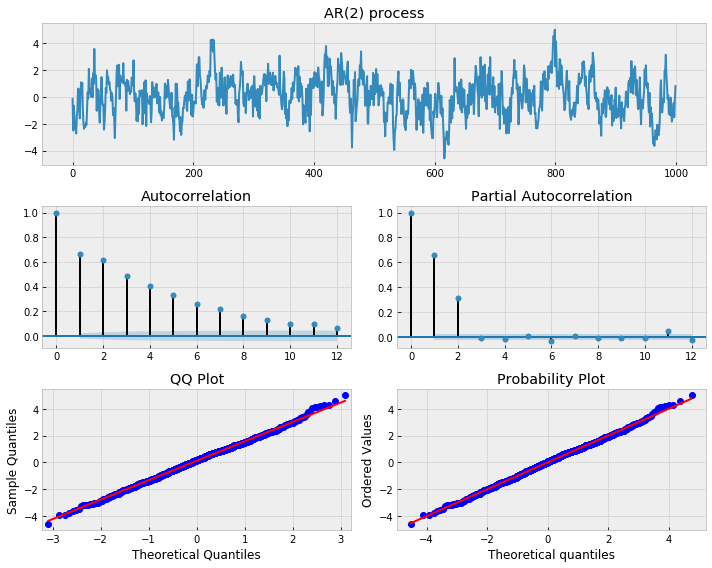

In [15]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

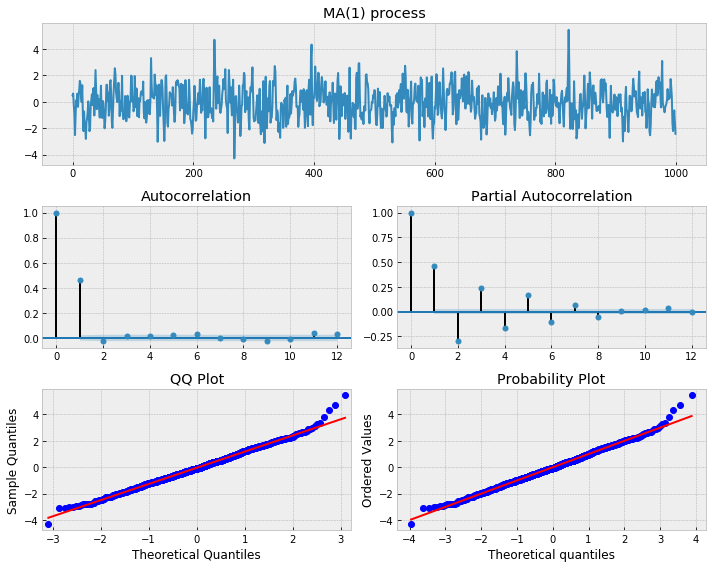

In [16]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

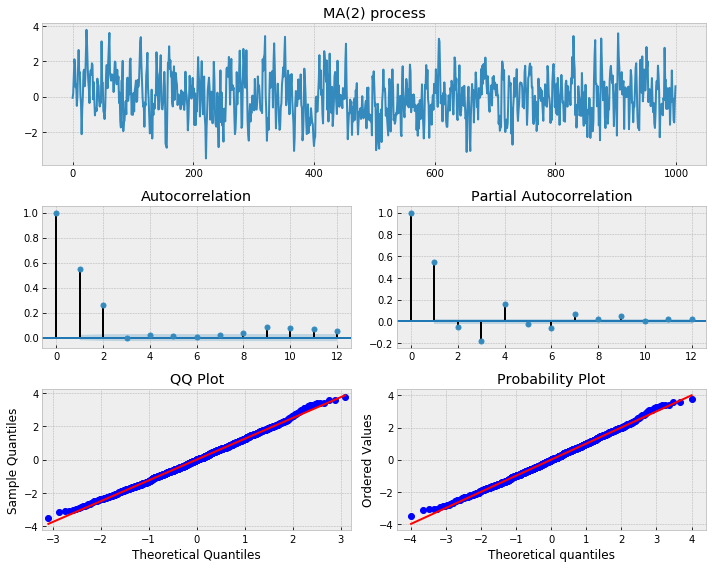

In [17]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

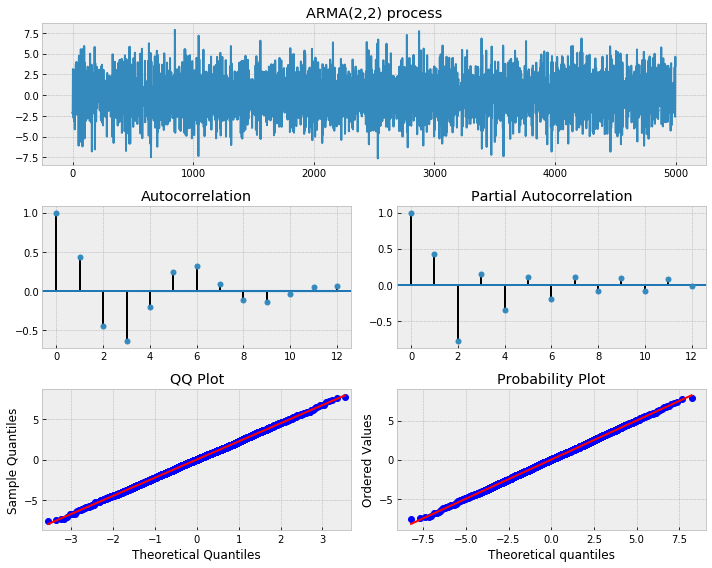

In [18]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")


In [19]:
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/statsmodels/base/mo

aic: 720.66783 | order: (1, 0)


In [20]:
best_mdl.predict()

/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


array([    0.        ,  1778.53507676,  -605.61278704, -2865.34674712,
        -216.81211508,  -598.66677807,   509.23347576, -1281.68370065,
         -11.70031517,    36.9090553 ,   195.78146932,  -987.66006889,
         299.96158034, -1894.79301356,  -679.83832361,  1899.23050877,
         375.39459226, -1239.52493599,  -439.05457981,  -355.08328032,
        1022.13024741,  -347.40747958, -4166.35678753,  2626.40037678,
       -3062.39564663, -1339.24433947,  1052.22198561, -3456.99899643,
         634.46760002,   719.81903981, -1077.7462644 ,  -781.9398454 ,
       -2165.72432306,  -516.03915567,  2162.30472554, -1762.24253824])

In [21]:
matplotlibdf = sales[['OrderDate', 'Sales']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
linechartData = matplotlibdf.groupby([pd.Grouper(freq='MS',key='OrderDate')]).sum()
linechartData = linechartData.reset_index()


from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
linechartData.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(linechartData) #fit the model with your dataframe


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [22]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
48,2018-01-01,43323.456758,33590.528042,53421.294343
49,2018-02-01,33730.695324,24209.318809,43470.079569
50,2018-03-01,70788.907869,61229.822884,80527.948305
51,2018-04-01,54148.980838,43979.592412,63559.977517
52,2018-05-01,57739.010458,47370.724152,67603.601537


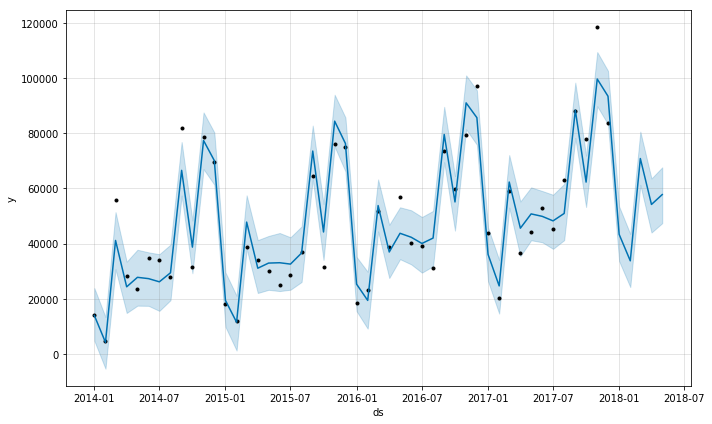

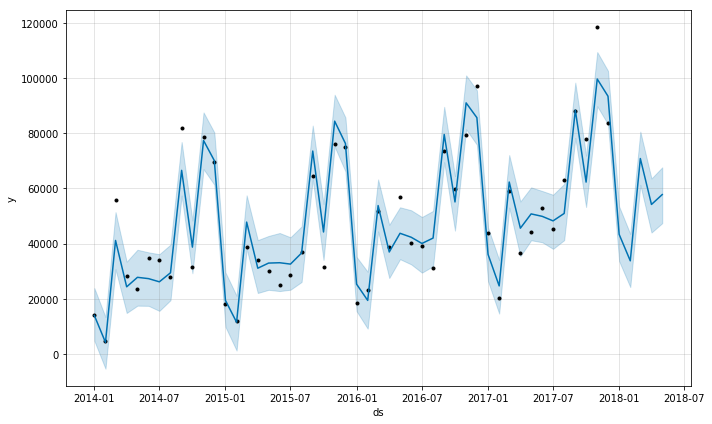

In [23]:
model.plot(forecast)

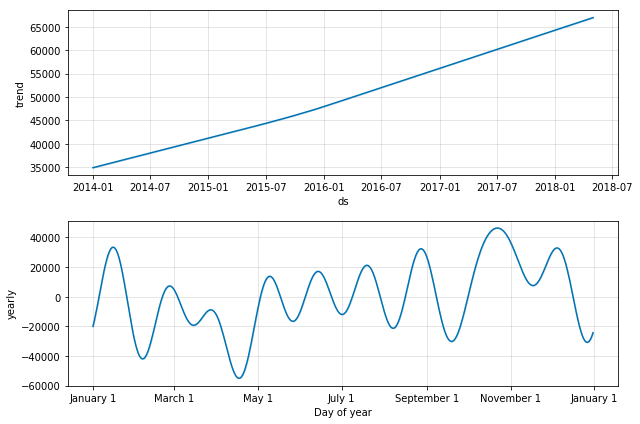

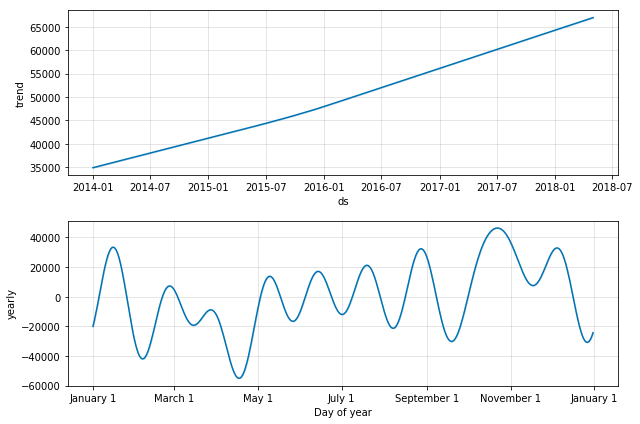

In [24]:
model.plot_components(forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


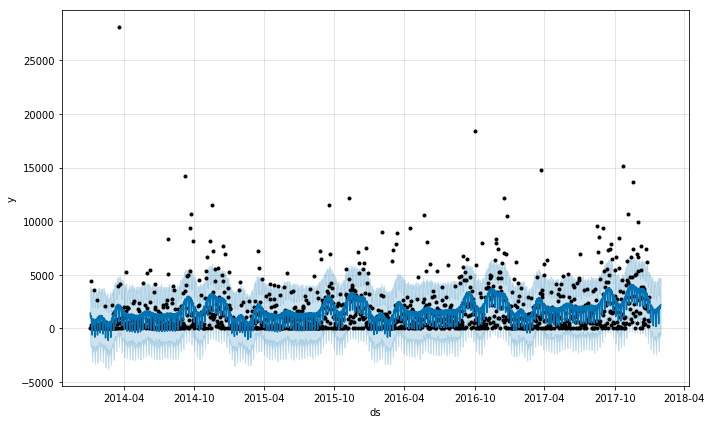

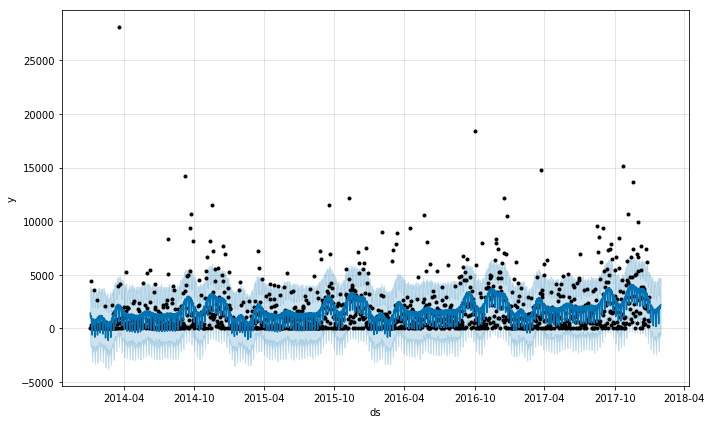

In [25]:
# let's try to make weekly predictions

matplotlibdf = sales[['OrderDate', 'Sales']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
#matplotlibdf.reset_index().set_index('OrderDate').resample('D', how='sum')
linechartData = matplotlibdf.groupby([pd.Grouper(freq='D',key='OrderDate')]).sum().reset_index().set_index('OrderDate')
#linechartData.reset_index()
#linechartData.set_index('OrderDate')
#linechartData = linechartData.ffill().reset_index()
#linechartData
#linechartData.sort_values(by=['OrderDate'], ascending=[True])

idx = pd.date_range('01-03-2014', '12-30-2017')
linechartData = linechartData.reindex(idx, fill_value=0)
linechartData = linechartData.reset_index()

from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
linechartData.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(linechartData) #fit the model with your dataframe

future = model.make_future_dataframe(periods = 30, freq = 'D')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
model.plot(forecast)

In [26]:
def me(df):
    return((df['yhat'] - df['y']).sum()/len(df['yhat']))
def mse(df):
    return((df['yhat'] - df['y']).pow(2).sum()/len(df))
def rmse(df):
    return(np.sqrt((df['yhat'] - df['y']).pow(2).sum()/len(df)))
def mae(df):
    return((df['yhat'] - df['y']).abs().sum()/len(df))
def mpe(df):
    return((df['yhat'] - df['y']).div(df['y']).sum()*(1/len(df)))
def mape(df):
    return((df['yhat'] - df['y']).div(df['y']).abs().sum()*(1/len(df)))

def all_metrics(model, df_cv = None):
    """Compute model fit metrics for time series.
    Computes the following metrics about each time series that has been through 
    Cross Validation;
    Mean Error (ME)
    Mean Squared Error (MSE)
    Root Mean Square Error (RMSE,
    Mean Absolute Error (MAE)
    Mean Percentage Error (MPE)
    Mean Absolute Percentage Error (MAPE)
    Parameters
    ----------
    df: A pandas dataframe. Contains y and yhat produced by cross-validation
    Returns
    -------
    A dictionary where the key = the error type, and value is the value of the error
    """

    

    df = []

    if df_cv is not None:
        df = df_cv
    else:
        # run a forecast on your own data with period = 0 so that it is in-sample data onlyl
        #df = model.predict(model.make_future_dataframe(periods=0))[['y', 'yhat']]
        df = (model
                .history[['ds', 'y']]
                .merge(
                    model.predict(model.make_future_dataframe(periods=0))[['ds', 'yhat']], 
                    how='inner', on='ds'
                    )
                )

    if 'yhat' not in df.columns:
        raise ValueError(
            'Please run Cross-Validation first before computing quality metrics.')

    return {
            'ME':me(df),
            'MSE':mse(df), 
            'RMSE': rmse(df), 
            'MAE': mae(df), 
            'MPE': mpe(df), 
            'MAPE': mape(df)
            }


In [27]:
matplotlibdf = sales[['OrderDate', 'Customer ID' , 'Sales']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
f = {'Sales':['sum', 'mean', 'count'], 'Customer ID':['nunique']}
linechartData = matplotlibdf.groupby([pd.Grouper(freq='D',key='OrderDate')]).agg(f)
linechartData['AvgSalePerCustomer'] = linechartData['Sales']['sum']/linechartData['Customer ID']['nunique']
print(linechartData)

                Sales                   Customer ID AvgSalePerCustomer
                  sum        mean count     nunique                   
OrderDate                                                             
2014-01-03    16.4480   16.448000     1           1          16.448000
2014-01-04   288.0600   96.020000     3           1         288.060000
2014-01-05    19.5360   19.536000     1           1          19.536000
2014-01-06  4407.1000  489.677778     9           3        1469.033333
2014-01-07    87.1580   43.579000     2           1          87.158000
2014-01-08     0.0000         NaN     0           0                NaN
2014-01-09    40.5440   20.272000     2           1          40.544000
2014-01-10    54.8300   27.415000     2           1          54.830000
2014-01-11     9.9400    9.940000     1           1           9.940000
2014-01-12     0.0000         NaN     0           0                NaN
2014-01-13  3553.7950  323.072273    11           4         888.448750
2014-0

In [28]:
matplotlibdf = sales[['OrderDate', 'Customer ID' , 'Sales', 'City']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
f = {'Sales':['sum'], 'Customer ID':['nunique']}
linechartData = matplotlibdf.groupby('City').agg(f)
linechartData['AvgSalePerCustomer'] = linechartData['Sales']['sum']/linechartData['Customer ID']['nunique']
print(linechartData.sort_values('AvgSalePerCustomer', ascending=False))

                        Sales Customer ID AvgSalePerCustomer
                          sum     nunique                   
City                                                        
Burbank             3247.1580           1        3247.158000
Beverly             2583.1900           1        2583.190000
Jamestown           4708.7900           2        2354.395000
San Gabriel         2061.0100           1        2061.010000
Bellingham          3790.2400           2        1895.120000
Round Rock          4854.0528           3        1618.017600
Cheyenne            1603.1360           1        1603.136000
Torrance            3132.2680           2        1566.134000
Passaic             1562.0860           1        1562.086000
Burlington         21668.0820          14        1547.720143
Noblesville         3091.1800           2        1545.590000
Great Falls         4605.5800           3        1535.193333
Lafayette          25036.2000          17        1472.717647
Eugene              1465

In [29]:
linechartData['AvgSalePerCustomer'].describe()

count     531.000000
mean      395.867213
std       393.339737
min         1.392000
25%       121.184000
50%       295.526000
75%       533.663500
max      3247.158000
Name: AvgSalePerCustomer, dtype: float64

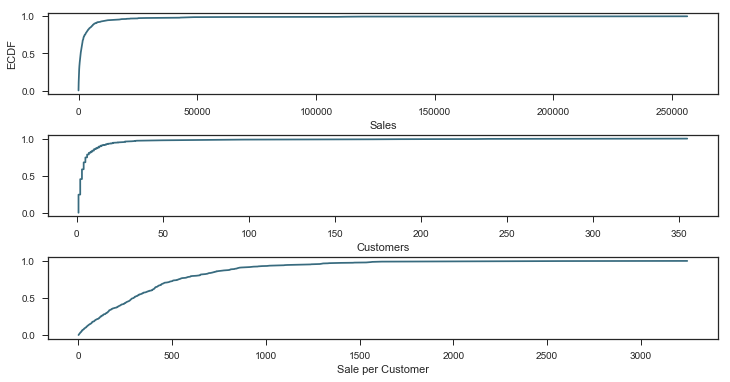

In [30]:
# ECDF: empirical cumulative distribution function

from statsmodels.distributions.empirical_distribution import ECDF

sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))
plt.subplots_adjust(hspace=.5)

plt.subplot(311)
cdf = ECDF(linechartData['Sales']['sum'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');



# plot second ECDF  
plt.subplot(312)
cdf = ECDF(linechartData['Customer ID']['nunique'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(linechartData['AvgSalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [31]:
matplotlibdf = sales[['OrderDate', 'Sub-Category' , 'Sales', 'Customer ID', 'Profit']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
matplotlibdf.groupby('Sub-Category')['Sales'].describe()


,count,mean,std,min,25%,50%,75%,max
Sub-Category,,,,,,,,
Accessories,775.0,215.974604,334.965015,0.990,47.9760,100.00000,239.9600,3347.370
Appliances,466.0,230.755710,388.949643,0.444,35.0550,82.69000,241.4400,2625.120
Art,796.0,34.068834,60.122465,1.344,7.9800,15.50400,36.4400,1113.024
Binders,1523.0,133.560560,563.251188,0.556,8.1170,18.56000,51.8485,9892.740
Bookcases,228.0,503.859633,638.748523,35.490,190.5000,306.82025,522.2850,4404.900
Chairs,617.0,532.332420,550.148243,26.640,191.9600,362.13600,662.8800,4416.174
Copiers,68.0,2198.941618,3175.665867,299.990,599.9875,1099.98000,2399.9600,17499.950
Envelopes,254.0,64.867724,84.351633,1.632,15.2575,29.04600,71.9475,604.656
Fasteners,217.0,13.936774,12.416593,1.240,5.6800,10.58400,17.9000,93.360


In [32]:
f = {'Sales':['sum'], 'Customer ID':['nunique'], 'Profit':['sum']}
matplotlibdf.groupby('Sub-Category').agg(f)

,Sales,Customer ID,Profit
,sum,nunique,sum
Sub-Category,,,
Accessories,167380.3180,474,41936.6357
Appliances,107532.1610,356,18138.0054
Art,27118.7920,494,6527.7870
Binders,203412.7330,650,30221.7633
Bookcases,114879.9963,195,-3472.5560
Chairs,328449.1030,407,26590.1663
Copiers,149528.0300,64,55617.8249
Envelopes,16476.4020,206,6964.1767


In [33]:
def f(row):
    if float(row['Discount']) > 0:
        return 1
    else:
        return 0

matplotlibdf = sales[['OrderDate', 'Category' , 'Sales', 'Discount', 'Region', 'Customer ID']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
matplotlibdf['is_discount'] = matplotlibdf.apply(f, axis=1)
matplotlibdf['month'] = matplotlibdf['OrderDate'].dt.month
matplotlibdf['weekday'] = matplotlibdf['OrderDate'].dt.weekday
print(matplotlibdf)

      OrderDate         Category      Sales  Discount   Region Customer ID  \
0    2016-11-08        Furniture   261.9600      0.00    South    CG-12520   
1    2016-11-08        Furniture   731.9400      0.00    South    CG-12520   
2    2016-06-12  Office Supplies    14.6200      0.00     West    DV-13045   
3    2015-10-11        Furniture   957.5775      0.45    South    SO-20335   
4    2015-10-11  Office Supplies    22.3680      0.20    South    SO-20335   
5    2014-06-09        Furniture    48.8600      0.00     West    BH-11710   
6    2014-06-09  Office Supplies     7.2800      0.00     West    BH-11710   
7    2014-06-09       Technology   907.1520      0.20     West    BH-11710   
8    2014-06-09  Office Supplies    18.5040      0.20     West    BH-11710   
9    2014-06-09  Office Supplies   114.9000      0.00     West    BH-11710   
10   2014-06-09        Furniture  1706.1840      0.20     West    BH-11710   
11   2014-06-09       Technology   911.4240      0.20     West  

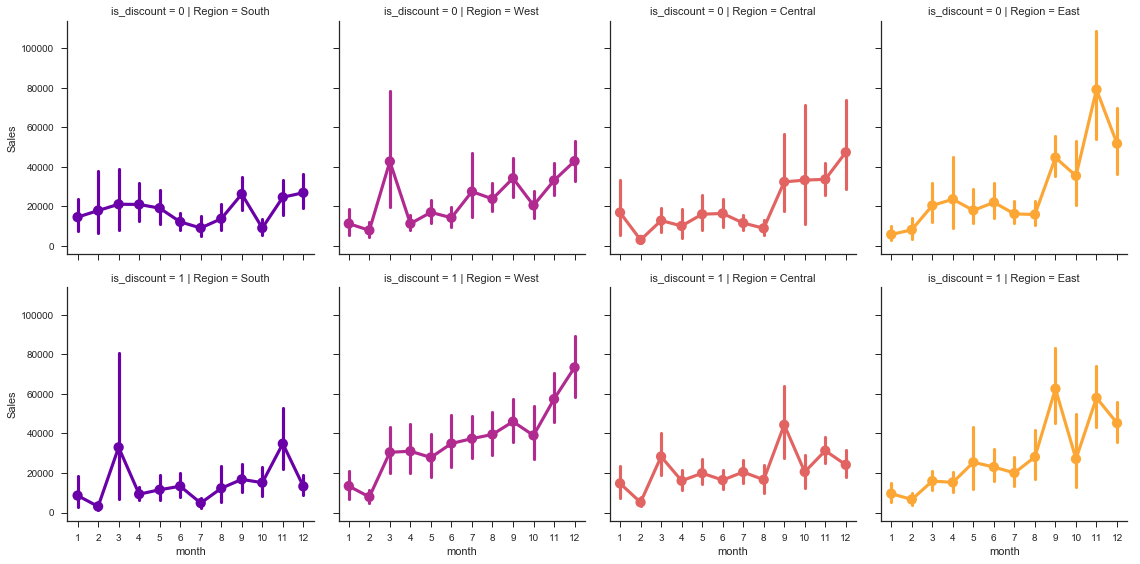

In [34]:
sns.factorplot(data = matplotlibdf, x = 'month', y = "Sales", 
               col = 'Region', # per store type in cols
               palette = 'plasma',
               hue = 'Region',
               row = 'is_discount', # per promo in the store in rows
               color = c,
               estimator=sum) 

# Show point estimates and confidence intervals using scatter plot glyphs.
# A point plot represents an estimate of central tendency for a numeric variable by the 
# position of scatter plot points and provides some indication of the uncertainty around that 
# bestimate using error bars.

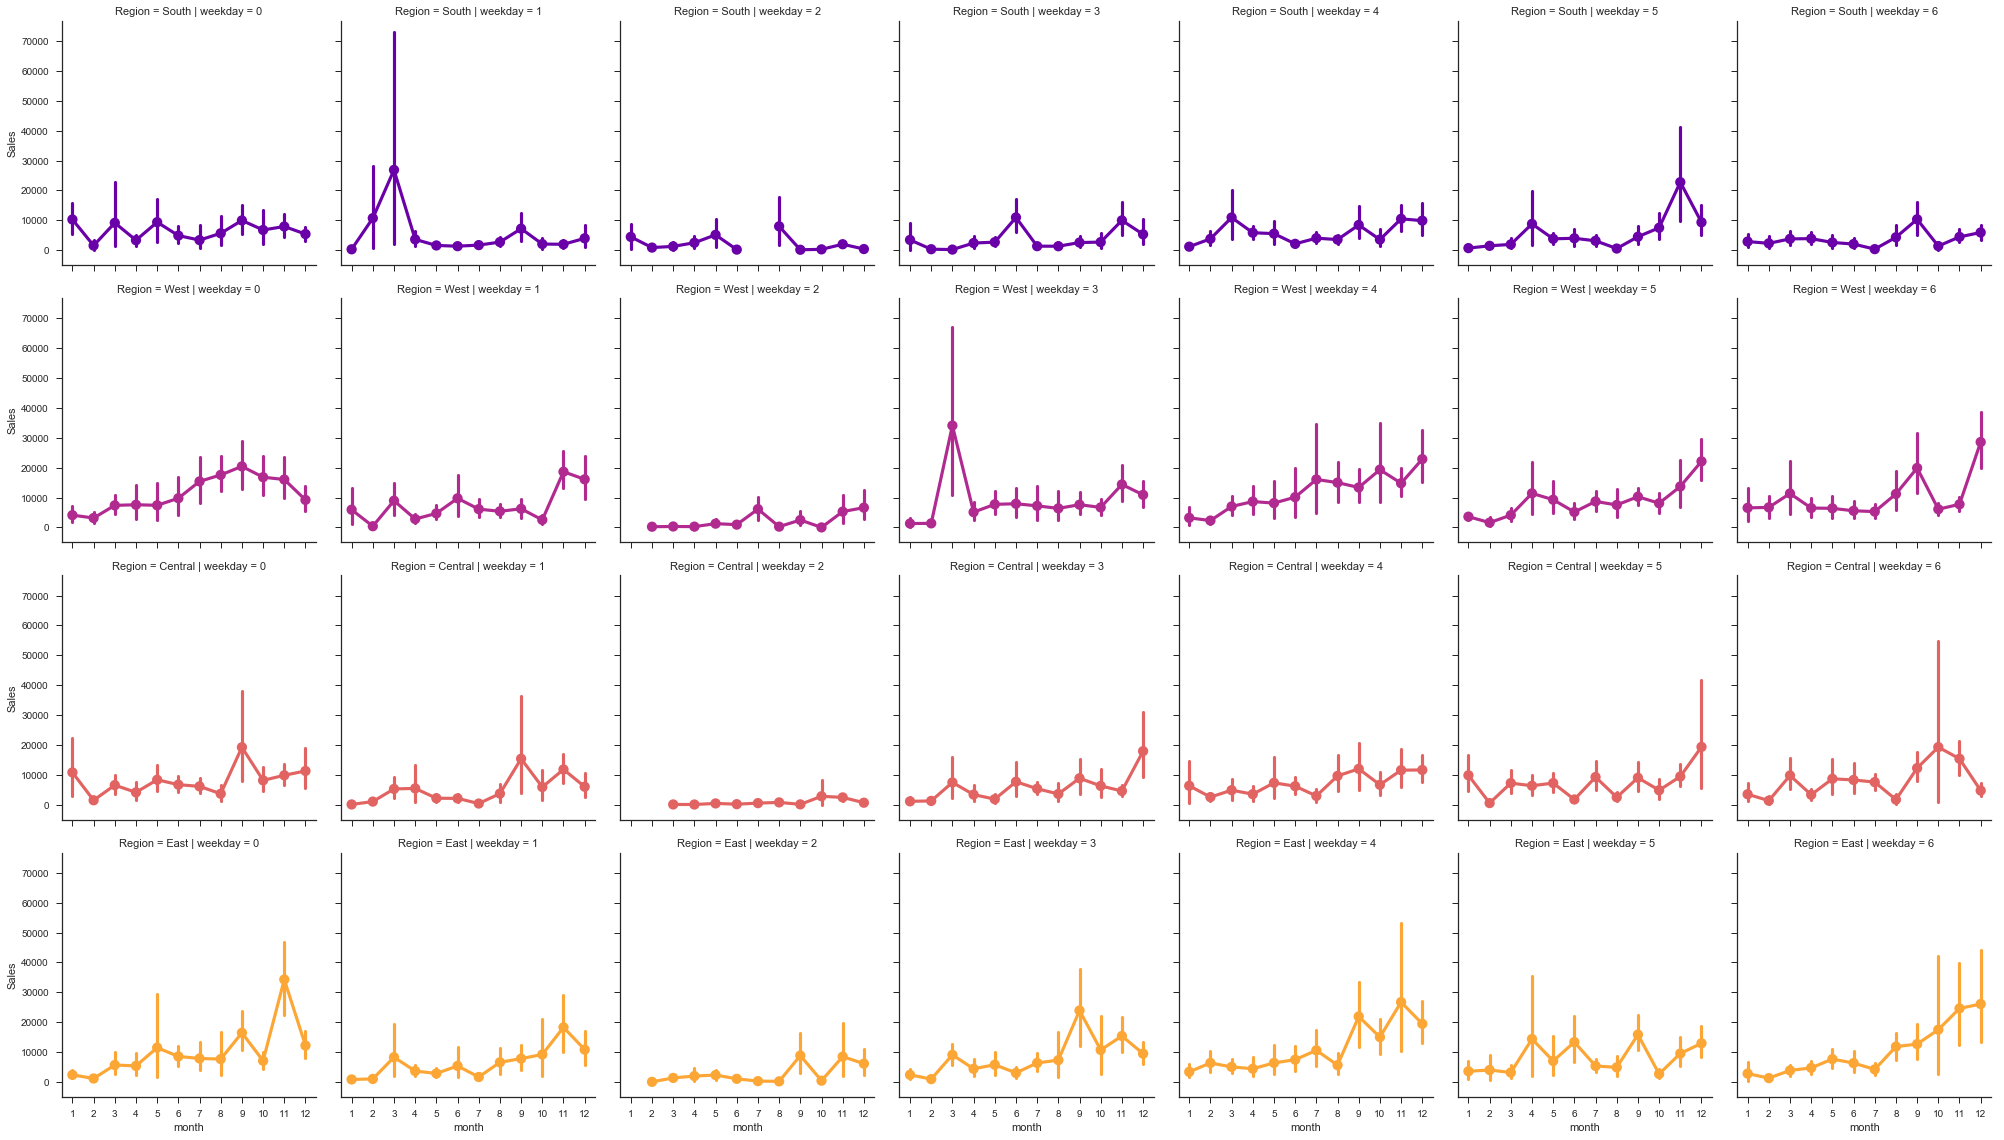

In [35]:
sns.factorplot(data = matplotlibdf, x = 'month', y = "Sales", 
               col = 'weekday', # per store type in cols
               palette = 'plasma',
               hue = 'Region',
               row = 'Region', # per store type in rows
               color = c,
               estimator=sum) 

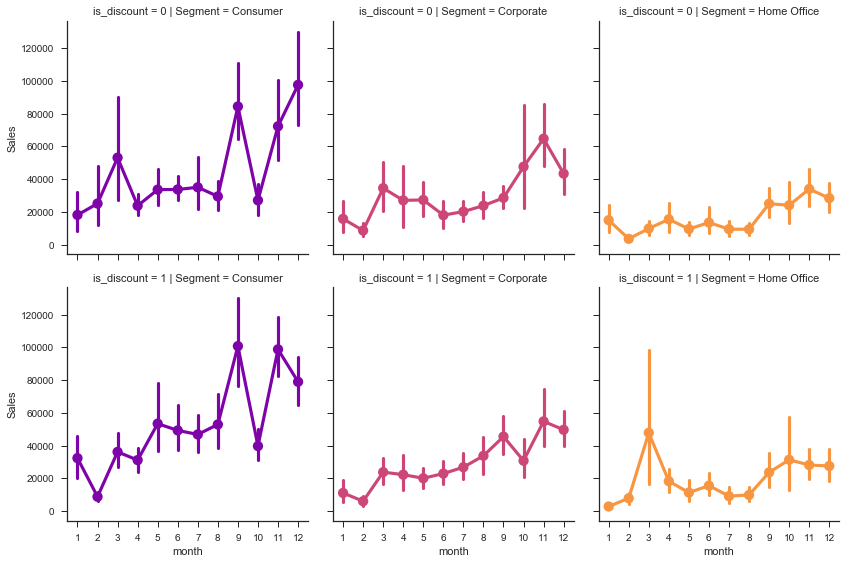

In [36]:
def f(row):
    if float(row['Discount']) > 0:
        return 1
    else:
        return 0

matplotlibdf = sales[['OrderDate', 'Segment' , 'Sales', 'Discount', 'Customer ID']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
matplotlibdf['is_discount'] = matplotlibdf.apply(f, axis=1)
matplotlibdf['month'] = matplotlibdf['OrderDate'].dt.month
matplotlibdf['weekday'] = matplotlibdf['OrderDate'].dt.weekday


sns.factorplot(data = matplotlibdf, x = 'month', y = "Sales", 
               col = 'Segment', # per store type in cols
               palette = 'plasma',
               hue = 'Segment',
               row = 'is_discount', # per promo in the store in rows
               color = c,
               estimator=sum) 

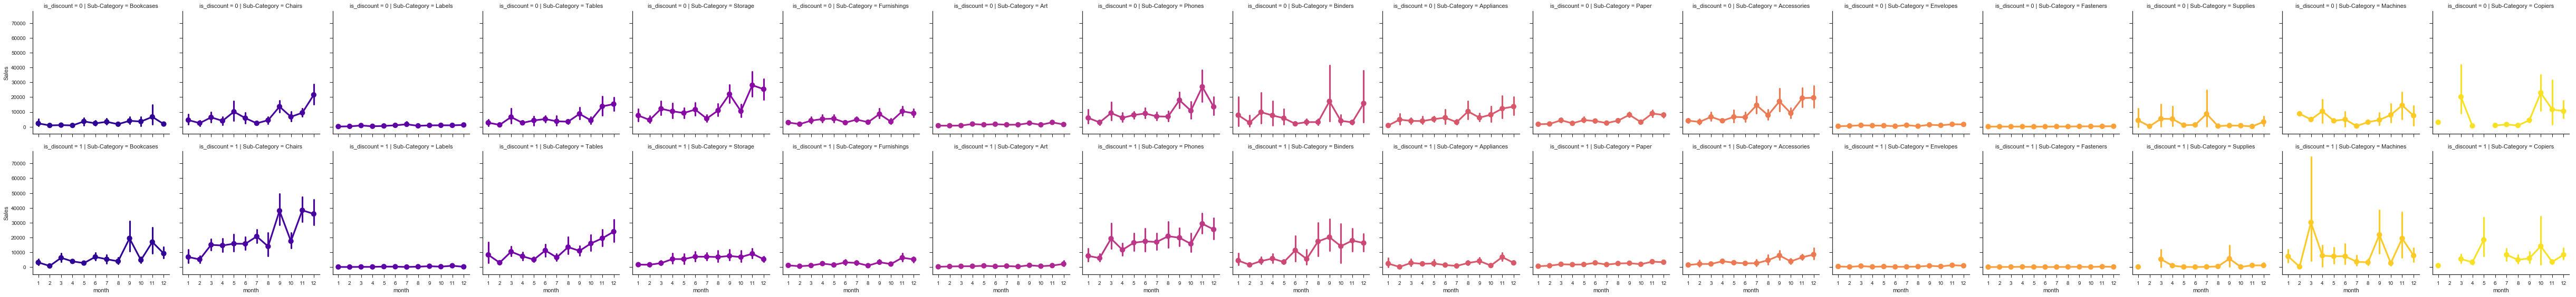

In [37]:
def f(row):
    if float(row['Discount']) > 0:
        return 1
    else:
        return 0

matplotlibdf = sales[['OrderDate', 'Sub-Category' , 'Sales', 'Discount', 'Customer ID']].copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
matplotlibdf['is_discount'] = matplotlibdf.apply(f, axis=1)
matplotlibdf['month'] = matplotlibdf['OrderDate'].dt.month
matplotlibdf['weekday'] = matplotlibdf['OrderDate'].dt.weekday


sns.factorplot(data = matplotlibdf, x = 'month', y = "Sales", 
               col = 'Sub-Category', # per store type in cols
               palette = 'plasma',
               hue = 'Sub-Category',
               row = 'is_discount', # per promo in the store in rows
               color = c,
               estimator=sum) 

### Let's see if we can find any correlation between the columns

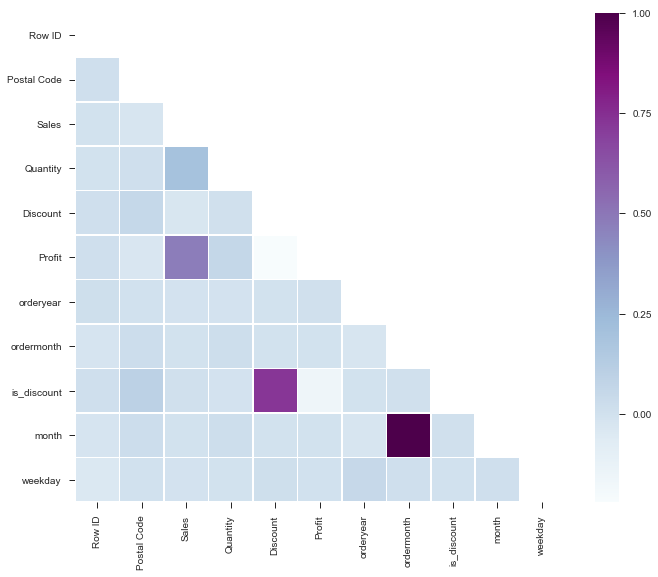

In [38]:
def f(row):
    if float(row['Discount']) > 0:
        return 1
    else:
        return 0

matplotlibdf = sales.copy()
matplotlibdf['OrderDate'] = pd.to_datetime(matplotlibdf['OrderDate'], format='%m/%d/%y')
matplotlibdf['is_discount'] = matplotlibdf.apply(f, axis=1)
matplotlibdf['month'] = matplotlibdf['OrderDate'].dt.month
matplotlibdf['weekday'] = matplotlibdf['OrderDate'].dt.weekday
corr_all = matplotlibdf.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
#plt.show()

### TakeAways

- Discounts make difference in West Region. In other regions, discount aren't useful
- Giving discounts to customers in Home Office Segment is very helpful.
- People buy chairs mostly in discount
- Chairs and Tables are sold around year end
- Discount doesn't matter in envelopes, fastners, labels and Art.
- Cities like Burlington, Lafayette, Minneapolis, Providence have lot of customers and good AvgSalesPerCustomer. To benefit from this fact, Store can consider proposing bigger variety of its products.


# Sales prediction on Rosmann Data

In [39]:
# store data
store = pd.read_csv("store.csv", 
                    low_memory = False)

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started - anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [40]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [41]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True)

In [42]:
# importing data
df = pd.read_csv("train.csv",low_memory = False)

df.info()

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Date     datetime64[ns]
Sales             int64
dtype: object

In [43]:

# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


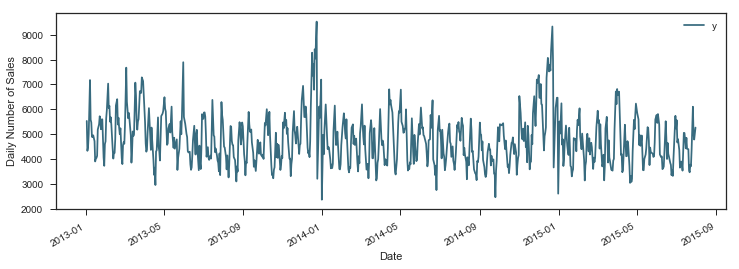

In [44]:

# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [45]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state-holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school-holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays

,ds,holiday
0,2015-06-04,state-holiday
1,2015-06-04,state-holiday
2,2015-06-04,state-holiday
3,2015-06-04,state-holiday
4,2015-06-04,state-holiday
5,2015-06-04,state-holiday
6,2015-06-04,state-holiday
7,2015-06-04,state-holiday
8,2015-06-04,state-holiday
9,2015-06-04,state-holiday


In [46]:
model = Prophet(interval_width = 0.95, holidays = holidays)
model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


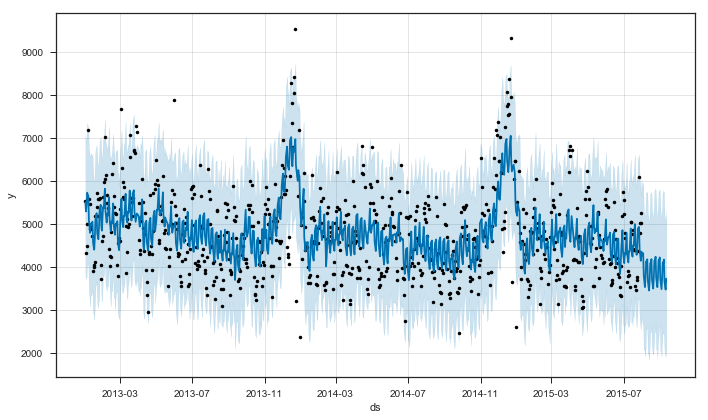

In [47]:
# predictions
forecast = model.predict(future_dates)

# preditions for last week
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
model.plot(forecast);


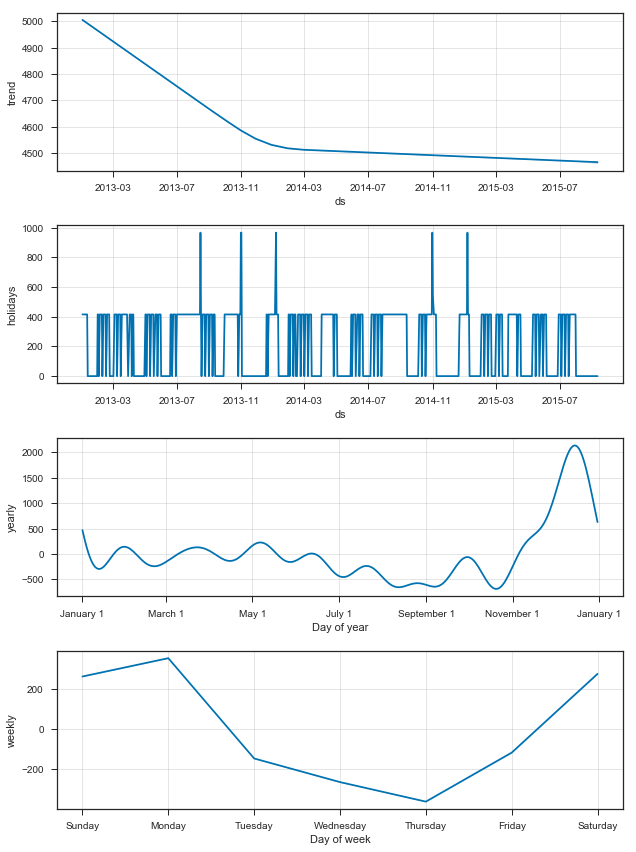

In [48]:
model.plot_components(forecast);

In [49]:
all_metrics(model)

{'ME': -0.18364937928120184,
 'MSE': 693623.275330607,
 'RMSE': 832.840486126009,
 'MAE': 674.4633013631615,
 'MPE': 0.030687559859972784,
 'MAPE': 0.1475343174923204}

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

### Prophet only requires ds and y to predict future values. Let's now perform multiple regression

In [121]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [122]:
train = pd.read_csv("train.csv",parse_dates = True, index_col = 'Date')
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train = train.reset_index()
df_new = pd.merge(train, store, how='left', on='Store')
df_new.columns.values

/Users/vijaynandwani/anaconda3/envs/pallavi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day',
       'WeekOfYear', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype=object)

In [123]:
df_new = df_new.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

In [124]:
df_new.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


In [125]:
df_new = df_new[df_new.Open != 0]
df_new = df_new.drop('Open', axis=1) #it's useless now
df_new = df_new[df_new.Sales != 0]

In [126]:
# Converting state holiday to string as other values are in string (a,b,c)
df_new.loc[df_new.StateHoliday == 0,'StateHoliday'] = df_new.loc[df_new.StateHoliday == 0,'StateHoliday'].astype(str)

In [127]:
# calculate weekly average sales
sales = df_new[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()
sales.head()

,Year,Month,Store,AvgSales
0,2013,1,1,4939.653846
1,2013,1,2,4429.653846
2,2013,1,3,6371.269231
3,2013,1,4,9027.423077
4,2013,1,5,4209.307692


In [128]:
# Time to merge them!

df_new['sales_key']=df_new['Year'].map(str) + df_new['Month'].map(str) + df_new['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [129]:
# drop extra columns
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
df_new = pd.merge(df_new, sales, how='left', on=('sales_key'))

In [130]:
# Avg number of customers

cust = df_new[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()
df_new['cust_key']=df_new['Year'].map(str) + df_new['Month'].map(str) + df_new['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

In [131]:
df_new = df_new.drop('Customers', axis=1)# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

In [132]:
df_new = pd.merge(df_new, cust, how="left", on=('cust_key'))

In [133]:
df_new['StateHoliday'] = df_new.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

In [134]:
df_new = df_new.drop(['cust_key','sales_key','Store', 'Date'], axis=1)

In [135]:
X = df_new.drop('Sales', axis=1)
y = df_new.Sales

In [136]:
xd = X.copy()
xd = pd.get_dummies(xd)
xd.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,AvgSales,AvgCustomer,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,5,1,0,1,2015,7,31,31,1270.0,0,4491.333333,519.407407,0,0,1,0,1,0,0
1,5,1,0,1,2015,7,31,31,570.0,1,4954.259259,621.222222,1,0,0,0,1,0,0
2,5,1,0,1,2015,7,31,31,14130.0,1,6797.592593,682.888889,1,0,0,0,1,0,0
3,5,1,0,1,2015,7,31,31,620.0,0,10256.851852,1294.259259,0,0,1,0,0,0,1
4,5,1,0,1,2015,7,31,31,29910.0,0,4599.629630,521.703704,1,0,0,0,1,0,0


In [137]:
# label nominal variables for tree based regression
xl = X.copy()

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
xl.StateHoliday = label.fit_transform(xl.StateHoliday)
xl.Assortment = label.fit_transform(xl.Assortment)
xl.StoreType = label.fit_transform(xl.StoreType)

# train test split

# split training and test datasets
from sklearn.cross_validation import train_test_split
xd_train,xd_test,yd_train,yd_test = train_test_split(xd,y,test_size=0.3, random_state=1)
xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.3, random_state=1)

xd_train.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,AvgSales,AvgCustomer,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
214809,4,0,0,0,2014,12,11,50,35280.0,0,5355.555556,551.296296,1,0,0,0,0,0,1
598561,3,1,0,0,2013,11,6,45,30360.0,0,6658.961538,566.769231,1,0,0,0,0,0,1
736221,6,0,0,0,2013,6,15,24,220.0,1,11358.960000,1388.320000,1,0,0,0,0,0,1
542693,6,0,0,0,2013,12,21,51,2930.0,0,7701.000000,678.458333,0,0,0,1,1,0,0
332170,1,1,0,1,2014,7,28,31,50.0,0,6294.370370,513.888889,0,0,0,1,0,0,1


### Linear Regression

In [220]:
from sklearn.linear_model import LinearRegression
lin= LinearRegression()
linreg = lin.fit(xd_train, yd_train)

In [221]:
# definte RMSE function
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  
  
# get cross validation scores 
yd_predicted = linreg.predict(xd_train)
yd_test_predicted = linreg.predict(xd_test)

linear_train_score = linreg.score(xd_train, yd_train)
linear_test_score = linreg.score(xd_test, yd_test)
linear_train_mape = mape(yd_train, yd_predicted)
linear_test_mape = mape(yd_test, yd_test_predicted)
print("Regresion Model Score" , ":" , linear_train_score , "," , 
      "Out of Sample Test Score" ,":" , linear_test_score)
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", linear_train_mape,
      "Testing MAPE", ":", linear_test_mape)

Regresion Model Score : 0.7486872962950807 , Out of Sample Test Score : 0.7482884273948067
Training RMSE : 1552.892778436124 Testing RMSE : 1556.0327257032734
Training MAPE : 16.99620812052566 Testing MAPE : 17.053657649224977


Text(0.5,1,'Residual plot in Linear')

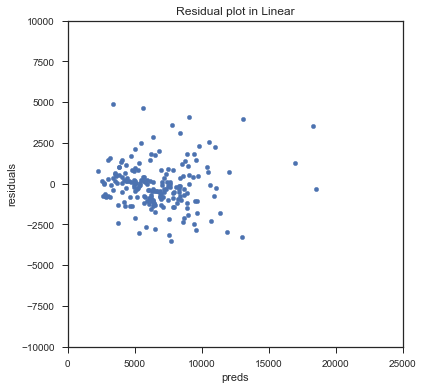

In [222]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":yd_test_predicted, "true":yd_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds = preds.sample(n=200)
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.axis([0, 25000, -10000, 10000])
plt.title("Residual plot in Linear")

### Bayesian Ridge Regression

In [223]:
from sklearn.linear_model import BayesianRidge
rdg = BayesianRidge()
rdgreg = rdg.fit(xd_train, yd_train)

In [224]:

yd_predicted = rdgreg.predict(xd_train)
yd_test_predicted = rdgreg.predict(xd_test)

ridge_train_score = rdgreg.score(xd_train, yd_train)
ridge_test_score = rdgreg.score(xd_test, yd_test)
ridge_train_mape = mape(yd_train, yd_predicted)
ridge_test_mape = mape(yd_test, yd_test_predicted)

# validation
print("Regresion Model Score" , ":" , ridge_train_score , "," ,
      "Out of Sample Test Score" ,":" , ridge_test_score)
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", ridge_train_mape,
      "Testing MAPE", ":", ridge_test_mape)

Regresion Model Score : 0.7486872941067197 , Out of Sample Test Score : 0.7482882999857583
Training RMSE : 1552.892785197202 Testing RMSE : 1556.0331195123892
Training MAPE : 16.996135206429493 Testing MAPE : 17.053588022278625


Text(0.5,1,'Residual plot in Bayesian Ridge')

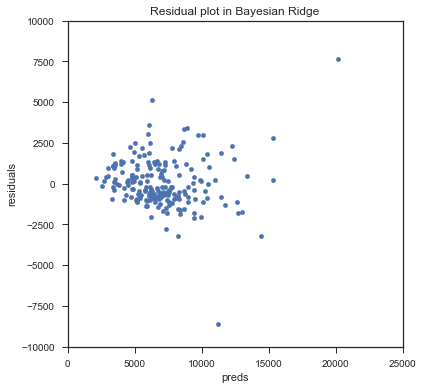

In [225]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":yd_test_predicted, "true":yd_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds = preds.sample(n=200)
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.axis([0, 25000, -10000, 10000])
plt.title("Residual plot in Bayesian Ridge")

###  LARS Lasso Regression

In [226]:
from sklearn.linear_model import LassoLars
las = LassoLars(alpha=0.3, fit_intercept=False, normalize=True)
lasreg = las.fit(xd_train, yd_train)

In [227]:

yd_predicted = lasreg.predict(xd_train)
yd_test_predicted = lasreg.predict(xd_test)


lasso_train_score = lasreg.score(xd_train, yd_train)
lasso_test_score = lasreg.score(xd_test, yd_test)
lasso_train_mape = mape(yd_train, yd_predicted)
lasso_test_mape = mape(yd_test, yd_test_predicted)


print("Regresion Model Score" , ":" , lasso_train_score , "," ,
      "Out of Sample Test Score" ,":" , lasso_test_score)
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", lasso_train_mape,
      "Testing MAPE", ":", lasso_test_mape)

Regresion Model Score : 0.7486548608147864 , Out of Sample Test Score : 0.7482757514380954
Training RMSE : 1552.9929866573425 Testing RMSE : 1556.0719053781515
Training MAPE : 16.99090592730715 Testing MAPE : 17.04779653117055


Text(0.5,1,'Residual plot in LARS Lasso')

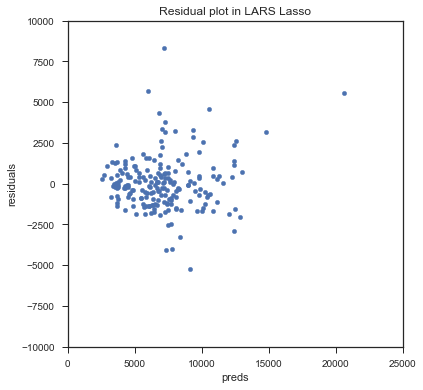

In [228]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":yd_test_predicted, "true":yd_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds = preds.sample(n=200)
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.axis([0, 25000, -10000, 10000])
plt.title("Residual plot in LARS Lasso")

### Decision Tree Regression

In [229]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(min_samples_leaf=20)
treereg = tree.fit(xl_train, yl_train)

In [230]:
yl_predicted = treereg.predict(xl_train)
yl_test_predicted = treereg.predict(xl_test)

decision_train_score = treereg.score(xl_train, yl_train)
decision_test_score = treereg.score(xl_test, yl_test)
decision_train_mape = mape(yl_train, yl_predicted)
decision_test_mape = mape(yl_test, yl_test_predicted)

print("Regresion Model Score" , ":" , decision_train_score , "," ,
      "Out of Sample Test Score" ,":" , decision_test_score)
print("Training RMSE", ":", rmse(yl_train, yl_predicted),
      "Testing RMSE", ":", rmse(yl_test, yl_test_predicted))
print("Training MAPE", ":", decision_train_mape,
      "Testing MAPE", ":", decision_test_mape)

Regresion Model Score : 0.9027583009397228 , Out of Sample Test Score : 0.8746215340532151
Training RMSE : 965.9630593620384 Testing RMSE : 1098.1928479490336
Training MAPE : 9.775973915806745 Testing MAPE : 11.225769676560038


Text(0.5,1,'Residual plot in Decision Tree')

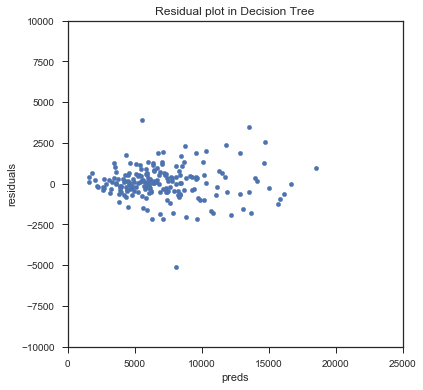

In [231]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":yl_test_predicted, "true":yl_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds = preds.sample(n=200)
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.axis([0, 25000, -10000, 10000])
plt.title("Residual plot in Decision Tree")

### Random Forest Regression

In [233]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(xl_train, yl_train)

In [234]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(xl_train, yl_train)
yl_predicted = rdfreg.predict(xl_train)
yl_test_predicted = rdfreg.predict(xl_test)

randomforest_train_score = rdfreg.score(xl_train, yl_train)
randomforest_test_score = rdfreg.score(xl_test, yl_test)
randomforest_train_mape = mape(yl_train, yl_predicted)
randomforest_test_mape = mape(yl_test, yl_test_predicted)

print("Regresion Model Score" , ":" , randomforest_train_score , "," ,
      "Out of Sample Test Score" ,":" , randomforest_test_score)   
print("Training RMSE", ":", rmse(yl_train, yl_predicted),
      "Testing RMSE", ":", rmse(yl_test, yl_test_predicted))
print("Training MAPE", ":", randomforest_train_mape,
      "Testing MAPE", ":", randomforest_test_mape)

Regresion Model Score : 0.9877708225256921 , Out of Sample Test Score : 0.9193156476149353
Training RMSE : 342.5570207957362 Testing RMSE : 880.9713680060886
Training MAPE : 3.420060947848951 Testing MAPE : 9.03730573775501


Text(0.5,1,'Residual plot in Random Forest Tree')

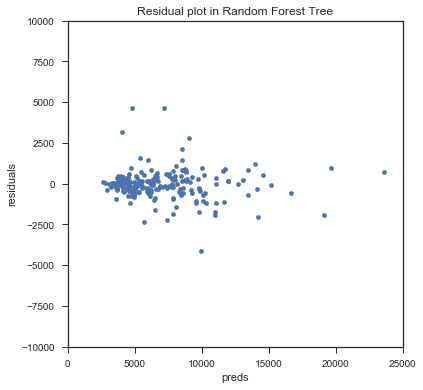

In [235]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":yl_test_predicted, "true":yl_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds = preds.sample(n=200)
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.axis([0, 25000, -10000, 10000])
plt.title("Residual plot in Random Forest Tree")

### K-Nearest Neighbors Regression

In [236]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 30)
knnreg = knn.fit(xd_train, yd_train)

In [237]:
yd_predicted = knnreg.predict(xd_train)
yd_test_predicted = knnreg.predict(xd_test)

knn_train_score = knnreg.score(xd_train, yd_train)
knn_test_score = knnreg.score(xd_test, yd_test)
knn_train_mape = mape(yd_train, yd_predicted)
knn_test_mape = mape(yd_test, yd_test_predicted)

print("Regresion Model Score" , ":" , knn_train_score , "," ,
      "Out of Sample Test Score" ,":" , knn_test_score)
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", knn_train_mape,
      "Testing MAPE", ":", knn_test_mape)

Regresion Model Score : 0.6514919969772337 , Out of Sample Test Score : 0.6277013414400041
Training RMSE : 1828.6922605326138 Testing RMSE : 1892.399701290796
Training MAPE : 21.983167017591406 Testing MAPE : 22.787960576353292


Text(0.5,1,'Residual plot in Knn')

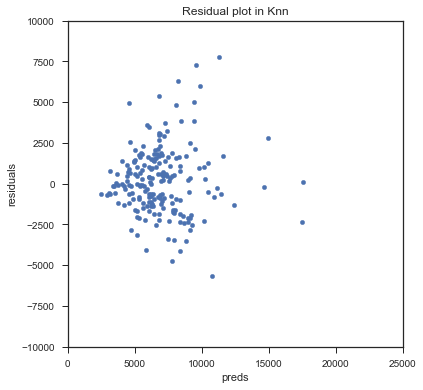

In [238]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":yd_test_predicted, "true":yd_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds = preds.sample(n=200)
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.axis([0, 25000, -10000, 10000])
plt.title("Residual plot in Knn")

### Plotting comparison between different models

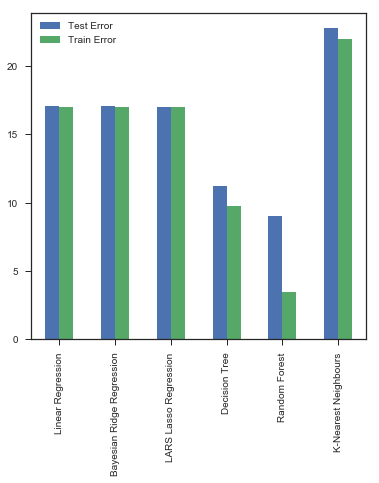

In [240]:
train_error=[linear_train_mape,ridge_train_mape,lasso_train_mape,decision_train_mape,randomforest_train_mape, knn_train_mape]
test_error=[linear_test_mape,ridge_test_mape,lasso_test_mape,decision_test_mape,randomforest_test_mape, knn_test_mape]

col={'Train Error':train_error,'Test Error':test_error}
models=['Linear Regression','Bayesian Ridge Regression','LARS Lasso Regression','Decision Tree','Random Forest', 'K-Nearest Neighbours']
df=pd.DataFrame(data=col,index=models)
df.plot(kind='bar')

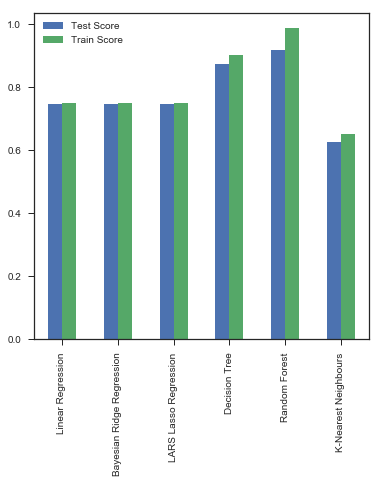

In [242]:
train_score=[linear_train_score,ridge_train_score,lasso_train_score,decision_train_score,randomforest_train_score, knn_train_score]
test_score=[linear_test_score,ridge_test_score,lasso_test_score,decision_test_score,randomforest_test_score, knn_test_score]

col={'Train Score':train_score,'Test Score':test_score}
models=['Linear Regression','Bayesian Ridge Regression','LARS Lasso Regression','Decision Tree','Random Forest', 'K-Nearest Neighbours']
df=pd.DataFrame(data=col,index=models)
df.plot(kind='bar')

### Feature importance

Text(0.5,0,'Relative Importance')

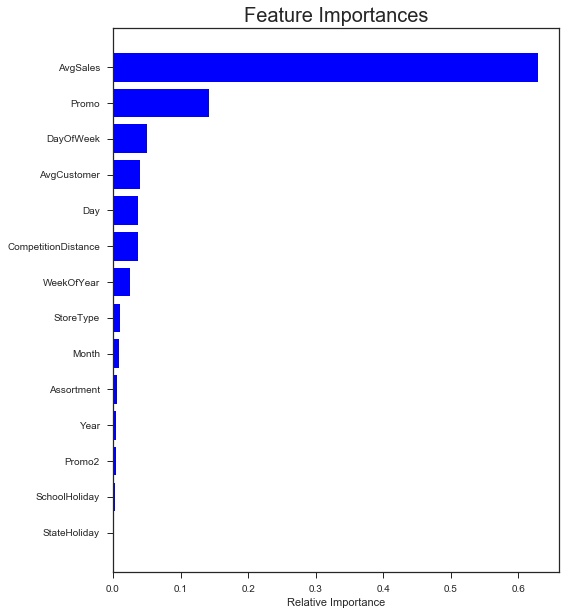

In [244]:
features = xl_train.columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

### Trying out the XGBOOST Approach

In [245]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

Tuning Parameters
- eta: Step size used in updating weights. Lower value means slower training but better convergence.
- num_round: Total number of iterations.
- subsample: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- colsample_bytree: The ratio of features used in each iteration, default 1.
- max_depth: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- early_stopping_rounds: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [246]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [247]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor # wrapper

In [249]:
# XGB with xgboost library
yl_train = np.log(yl_train)
yl_test = np.log(yl_test)
dtrain = xgb.DMatrix(xl_train, yl_train)
dtest = xgb.DMatrix(xl_test, yl_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.44245	test-rmse:7.44272	train-rmspe:0.99953	test-rmspe:0.99953
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.69918	test-rmse:6.69954	train-rmspe:0.998834	test-rmspe:0.998834
[2]	train-rmse:6.03026	test-rmse:6.03064	train-rmspe:0.997581	test-rmspe:0.997581
[3]	train-rmse:5.42801	test-rmse:5.4284	train-rmspe:0.99548	test-rmspe:0.99548
[4]	train-rmse:4.8865	test-rmse:4.88687	train-rmspe:0.992146	test-rmspe:0.992147
[5]	train-rmse:4.39873	test-rmse:4.39912	train-rmspe:0.987184	test-rmspe:0.987186
[6]	train-rmse:3.95983	test-rmse:3.96023	train-rmspe:0.980133	test-rmspe:0.980141
[7]	train-rmse:3.56503	test-rmse:3.56544	train-rmspe:0.970545	test-rmspe:0.970564
[8]	train-rmse:3.20978	test-rmse:3.21018	train-rmspe:0.958056	test-rmspe:0.958096
[9]	train-rmse:2.89001	test-rmse:2.89041	train-rmspe:0.942381	test-rmspe:0.942461
[10]	train-rmse:2.6024	test-rmse:2.60282	

### Let's try out Hyperparameter Tuning

In [251]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(xl_train, yl_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [253]:
import scipy.stats as st
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(xl_train, yl_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

KeyboardInterrupt: 

In [260]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 16, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.90223	test-rmse:7.90249	train-rmspe:0.999764	test-rmspe:0.999764
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:7.55233	test-rmse:7.55262	train-rmspe:0.999596	test-rmspe:0.999595
[2]	train-rmse:7.21794	test-rmse:7.21823	train-rmspe:0.99937	test-rmspe:0.99937
[3]	train-rmse:6.89827	test-rmse:6.89857	train-rmspe:0.999072	test-rmspe:0.999072
[4]	train-rmse:6.59301	test-rmse:6.59331	train-rmspe:0.998683	test-rmspe:0.998683
[5]	train-rmse:6.30106	test-rmse:6.30139	train-rmspe:0.998187	test-rmspe:0.998187
[6]	train-rmse:6.02208	test-rmse:6.02243	train-rmspe:0.997558	test-rmspe:0.997558
[7]	train-rmse:5.75559	test-rmse:5.75594	train-rmspe:0.996768	test-rmspe:0.996769
[8]	train-rmse:5.50092	test-rmse:5.50127	train-rmspe:0.995792	test-rmspe:0.995793
[9]	train-rmse:5.25746	test-rmse:5.25783	train-rmspe:0.994602	test-rmspe:0.994603
[10]	train-rmse:5.02491	test-rmse:5.0

KeyboardInterrupt: 

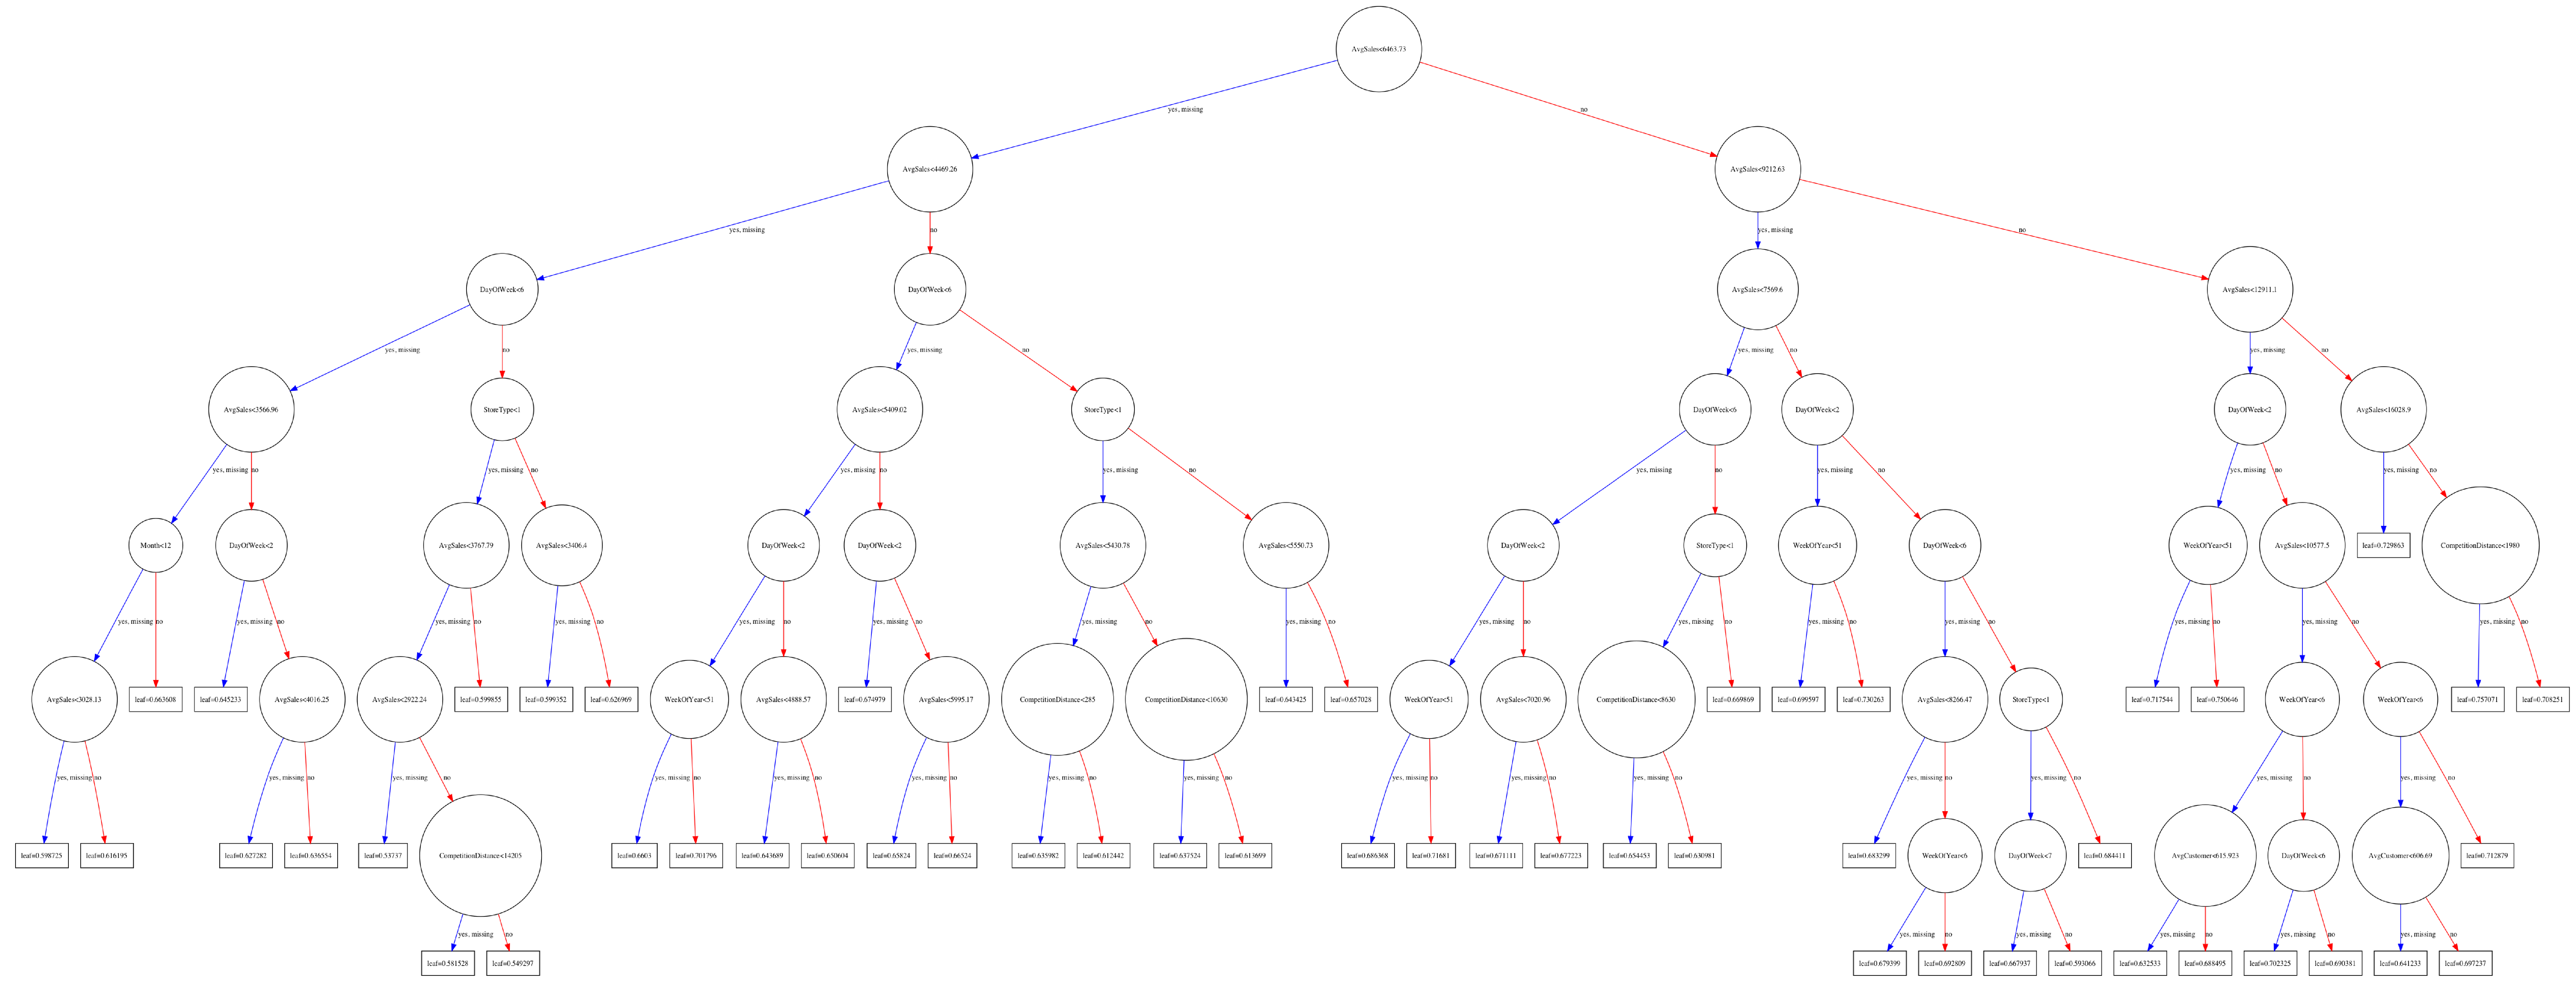

In [263]:
xgb.plot_tree(xgb_model, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

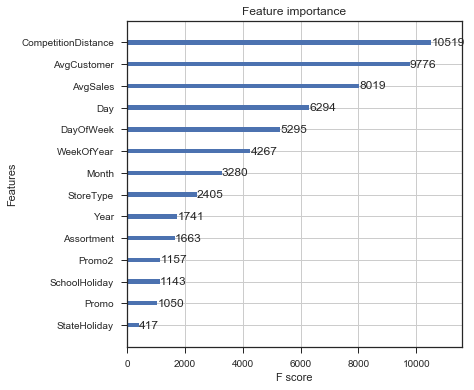

In [264]:
xgb.plot_importance(xgb_model)